In [1]:
pip install transformers datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00


# Image classification

In [2]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/tjAIM7BOYhw?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

/usr/local/lib/python3.10/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Image classification assigns a label or class to an image. Unlike text or audio classification, the inputs are the
pixel values that comprise an image. There are many applications for image classification, such as detecting damage
after a natural disaster, monitoring crop health, or helping screen medical images for signs of disease.

This guide illustrates how to:

1. Fine-tune [ViT](https://huggingface.co/docs/transformers/main/en/tasks/model_doc/vit) on the [Food-101](https://huggingface.co/datasets/food101) dataset to classify a food item in an image.
2. Use your fine-tuned model for inference.

<Tip>
The task illustrated in this tutorial is supported by the following model architectures:

<!--This tip is automatically generated by `make fix-copies`, do not fill manually!-->

[BEiT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/beit), [BiT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/bit), [ConvNeXT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/convnext), [ConvNeXTV2](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/convnextv2), [CvT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/cvt), [Data2VecVision](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/data2vec-vision), [DeiT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/deit), [DiNAT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/dinat), [EfficientFormer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/efficientformer), [EfficientNet](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/efficientnet), [FocalNet](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/focalnet), [ImageGPT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/imagegpt), [LeViT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/levit), [MobileNetV1](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/mobilenet_v1), [MobileNetV2](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/mobilenet_v2), [MobileViT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/mobilevit), [MobileViTV2](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/mobilevitv2), [NAT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/nat), [Perceiver](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/perceiver), [PoolFormer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/poolformer), [RegNet](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/regnet), [ResNet](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/resnet), [SegFormer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/segformer), [SwiftFormer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/swiftformer), [Swin Transformer](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/swin), [Swin Transformer V2](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/swinv2), [VAN](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/van), [ViT](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/vit), [ViT Hybrid](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/vit_hybrid), [ViTMSN](https://huggingface.co/docs/transformers/main/en/tasks/../model_doc/vit_msn)
<!--End of the generated tip-->

</Tip>

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install transformers datasets evaluate
```

We encourage you to log in to your Hugging Face account to upload and share your model with the community. When prompted, enter your token to log in:

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Load Cat_Vs_Dogs-101 dataset

Start by loading a smaller subset of the Cat_Vs_Dogs-101 dataset from the 🤗 Datasets library. This will give you a chance to
experiment and make sure everything works before spending more time training on the full dataset.

In [4]:
from datasets import load_dataset

animals = load_dataset("cats_vs_dogs", split="train[:5000]")

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

Split the dataset's `train` split into a train and test set with the [train_test_split](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split) method:

In [5]:
animals = animals.train_test_split(test_size=0.2)

Then take a look at an example:

In [6]:
animals["train"][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 'labels': 0}

Each example in the dataset has two fields:

- `image`: a PIL image of the food item
- `label`: the label class of the food item

To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name
to an integer and vice versa:

In [7]:
labels = animals["train"].features["labels"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label
    print(i)

0
1


Now you can convert the label id to a label name:

In [8]:
id2label[str(0)]

'cat'

In [9]:
id2label[str(1)]

'dog'

## Preprocess

The next step is to load a ViT image processor to process the image into a tensor:

In [10]:
from transformers import AutoImageProcessor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

To avoid overfitting and to make the model more robust, add some data augmentation to the training part of the dataset.
Here we use Keras preprocessing layers to define the transformations for the training data (includes data augmentation),
and transformations for the validation data (only center cropping, resizing and normalizing). You can use `tf.image`or
any other library you prefer.

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

size = (image_processor.size["height"], image_processor.size["width"])

train_data_augmentation = keras.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="train_data_augmentation",
)

val_data_augmentation = keras.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="val_data_augmentation",
)

Next, create functions to apply appropriate transformations to a batch of images, instead of one image at a time.

In [12]:
import numpy as np
import tensorflow as tf
from PIL import Image


def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

Use 🤗 Datasets [set_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.set_transform) to apply the transformations on the fly:

In [13]:
animals["train"].set_transform(preprocess_train)
animals["test"].set_transform(preprocess_val)

As a final preprocessing step, create a batch of examples using `DefaultDataCollator`. Unlike other data collators in 🤗 Transformers, the
`DefaultDataCollator` does not apply additional preprocessing, such as padding.

In [14]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

## Evaluate

Including a metric during training is often helpful for evaluating your model's performance. You can quickly load an
evaluation method with the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load
the [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

In [15]:
import evaluate

accuracy = evaluate.load("accuracy")

Then create a function that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the accuracy:

In [16]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

Your `compute_metrics` function is ready to go now, and you'll return to it when you set up your training.

## Train

<Tip>

If you are unfamiliar with fine-tuning a model with Keras, check out the [basic tutorial](https://huggingface.co/docs/transformers/main/en/tasks/./training#train-a-tensorflow-model-with-keras) first!

</Tip>

To fine-tune a model in TensorFlow, follow these steps:
1. Define the training hyperparameters, and set up an optimizer and a learning rate schedule.
2. Instantiate a pre-trained model.
3. Convert a 🤗 Dataset to a `tf.data.Dataset`.
4. Compile your model.
5. Add callbacks and use the `fit()` method to run the training.
6. Upload your model to 🤗 Hub to share with the community.

Start by defining the hyperparameters, optimizer and learning rate schedule:

In [17]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 5
num_train_steps = len(animals["train"]) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

Then, load ViT with [TFAutoModelForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.TFAutoModelForImageClassification) along with the label mappings:

In [18]:
from transformers import TFAutoModelForImageClassification

model = TFAutoModelForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

tf_model.h5:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing TFViTForImageClassification: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
- This IS expected if you are initializing TFViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Convert your datasets to the `tf.data.Dataset` format using the [to_tf_dataset](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.to_tf_dataset) and your `data_collator`:

In [19]:
# converting our train dataset to tf.data.Dataset
tf_train_dataset = animals["train"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = animals["test"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

Configure the model for training with `compile()`:

In [20]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

To compute the accuracy from the predictions and push your model to the 🤗 Hub, use [Keras callbacks](https://huggingface.co/docs/transformers/main/en/tasks/../main_classes/keras_callbacks).
Pass your `compute_metrics` function to [KerasMetricCallback](https://huggingface.co/docs/transformers/main/en/tasks/../main_classes/keras_callbacks#transformers.KerasMetricCallback),
and use the [PushToHubCallback](https://huggingface.co/docs/transformers/main/en/tasks/../main_classes/keras_callbacks#transformers.PushToHubCallback) to upload the model:

In [21]:
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_eval_dataset)
push_to_hub_callback = PushToHubCallback(
    output_dir="animal_classifier",
    tokenizer=image_processor,
    save_strategy="no",
)
callbacks = [metric_callback, push_to_hub_callback]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:127: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/Ananya1997/animal_classifier into local empty directory.


Finally, you are ready to train your model! Call `fit()` with your training and validation datasets, the number of epochs,
and your callbacks to fine-tune the model:

In [22]:
model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/5
250/250 [==============================] - 392s 1s/step - loss: 0.0508 - val_loss: 0.0104 - accuracy: 1.0000
Epoch 2/5
250/250 [==============================] - 345s 1s/step - loss: 0.0075 - val_loss: 0.0055 - accuracy: 1.0000
Epoch 3/5
250/250 [==============================] - 358s 1s/step - loss: 0.0043 - val_loss: 0.0034 - accuracy: 1.0000
Epoch 4/5
250/250 [==============================] - 349s 1s/step - loss: 0.0027 - val_loss: 0.0022 - accuracy: 1.0000
Epoch 5/5
250/250 [==============================] - 374s 1s/step - loss: 0.0019 - val_loss: 0.0016 - accuracy: 1.0000


Upload file tf_model.h5:   0%|          | 1.00/328M [00:00<?, ?B/s]

To https://huggingface.co/Ananya1997/animal_classifier
   d9e1b10..ddc1700  main -> main

   d9e1b10..ddc1700  main -> main



Congratulations! You have fine-tuned your model and shared it on the 🤗 Hub. You can now use it for inference!


<Tip>

For a more in-depth example of how to finetune a model for image classification, take a look at the corresponding [PyTorch notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification.ipynb).

</Tip>

## Inference

Great, now that you've fine-tuned a model, you can use it for inference!

Load an image you'd like to run inference on:

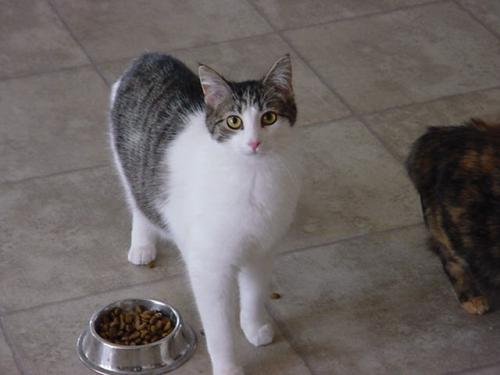

In [27]:
ds = load_dataset("cats_vs_dogs", split="train[5001:5011]")
image = ds["image"][0]
image

In [31]:
from transformers import pipeline

classifier = pipeline("image-classification", model="Ananya1997/animal_classifier")
classifier(image)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/343M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at Ananya1997/animal_classifier.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

[{'score': 0.9984440207481384, 'label': 'cat'},
 {'score': 0.0015560294268652797, 'label': 'dog'}]

You can also manually replicate the results of the `pipeline` if you'd like:


Load an image processor to preprocess the image and return the `input` as TensorFlow tensors:

In [32]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("Ananya1997/animal_classifier")
inputs = image_processor(image, return_tensors="tf")

Pass your inputs to the model and return the logits:

In [33]:
from transformers import TFAutoModelForImageClassification

model = TFAutoModelForImageClassification.from_pretrained("Ananya1997/animal_classifier")
logits = model(**inputs).logits

All model checkpoint layers were used when initializing TFViTForImageClassification.

All the layers of TFViTForImageClassification were initialized from the model checkpoint at Ananya1997/animal_classifier.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


Get the predicted label with the highest probability, and use the model's `id2label` mapping to convert it to a label:

In [34]:
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
model.config.id2label[predicted_class_id]

'cat'